# **Experiment 2: Loan Amount Prediction using Linear Regression**

**OBJECTIVE**

Apply Linear Regression to predict the loan amount sanctioned to users using the dataset provided.
Visualize and interpret the results to gain insights into the model performance.

**IMPLEMENTATION STEPS:**

**1. Load the dataset**

In [763]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = pd.read_csv('/content/drive/MyDrive/ml-lab/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/ml-lab/test.csv')

df = pd.DataFrame(data)

print(data.head())

  Customer ID               Name Gender  Age  Income (USD) Income Stability  \
0     C-36995   Frederica Shealy      F   56       1933.05              Low   
1     C-33999  America Calderone      M   32       4952.91              Low   
2      C-3770      Rosetta Verne      F   65        988.19             High   
3     C-26480         Zoe Chitty      F   65           NaN             High   
4     C-23459       Afton Venema      F   31       2614.77              Low   

  Profession     Type of Employment    Location  Loan Amount Request (USD)  \
0    Working            Sales staff  Semi-Urban                   72809.58   
1    Working                    NaN  Semi-Urban                   46837.47   
2  Pensioner                    NaN  Semi-Urban                   45593.04   
3  Pensioner                    NaN       Rural                   80057.92   
4    Working  High skill tech staff  Semi-Urban                  113858.89   

   ...  Credit Score No. of Defaults Has Active Credit C

**2. Pre-process the data:**
- Handle missing values
- Encode categorical variables
- Normalize or standardize the features

In [764]:
print(df.isnull().sum())

Customer ID                       0
Name                              0
Gender                           53
Age                               0
Income (USD)                   4576
Income Stability               1683
Profession                        0
Type of Employment             7270
Location                          0
Loan Amount Request (USD)         0
Current Loan Expenses (USD)     172
Expense Type 1                    0
Expense Type 2                    0
Dependents                     2493
Credit Score                   1703
No. of Defaults                   0
Has Active Credit Card         1566
Property ID                       0
Property Age                   4850
Property Type                     0
Property Location               356
Co-Applicant                      0
Property Price                    0
Loan Sanction Amount (USD)      340
dtype: int64


In [765]:
# removing outliers using histogram
df = df[df['Income (USD)'] <= 8000]
df = df[df['Current Loan Expenses (USD)'] >= 0]

# distribution approximately normal - imputing with mean
df['Credit Score'] = df['Credit Score'].fillna(df['Credit Score'].mean())

# distribution not normal - imputing with median
df['Income (USD)'] = df['Income (USD)'].fillna(df['Income (USD)'].median())
df['Current Loan Expenses (USD)'] = df['Current Loan Expenses (USD)'].fillna(df['Current Loan Expenses (USD)'].median())
df['Property Age'] = df['Property Age'].fillna(df['Property Age'].median())
df['Loan Sanction Amount (USD)'] = df['Loan Sanction Amount (USD)'].fillna(df['Loan Sanction Amount (USD)'].median())

# imputing categorical variable NaNs with mode
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Income Stability'] = df['Income Stability'].fillna(df['Income Stability'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Has Active Credit Card'] = df['Has Active Credit Card'].fillna(df['Has Active Credit Card'].mode()[0])
df['Property Location'] = df['Property Location'].fillna(df['Property Location'].mode()[0])
df['Co-Applicant'] = df['Co-Applicant'].replace(-999, df['Co-Applicant'].mode()[0])
# df['Type of Employment'] = df['Type of Employment'].fillna(df['Type of Employment'].mode()[0])

In [762]:
print(df.isnull().sum())

Customer ID                    0
Name                           0
Gender                         0
Age                            0
Income (USD)                   0
Income Stability               0
Profession                     0
Type of Employment             0
Location                       0
Loan Amount Request (USD)      0
Current Loan Expenses (USD)    0
Expense Type 1                 0
Expense Type 2                 0
Dependents                     0
Credit Score                   0
No. of Defaults                0
Has Active Credit Card         0
Property ID                    0
Property Age                   0
Property Type                  0
Property Location              0
Co-Applicant                   0
Property Price                 0
Loan Sanction Amount (USD)     0
dtype: int64


In [766]:
# columns like Customer ID and Name are identifiers, not features = drop
df = df.drop(['Customer ID', 'Name', 'Property ID'], axis=1)

# nominal variables = one hot encoding
df = pd.get_dummies(df, columns=['Gender', 'Profession',
                                 'Location', 'Property Location'
                                 ], drop_first=True)
df['Gender_M'] = df['Gender_M'].astype(int) # for heatmap

# ordinal variables = map
df['Income Stability'] = df['Income Stability'].map({'Low': 0, 'High': 1})
df['Has Active Credit Card'] = df['Has Active Credit Card'].map({
    'Unpossessed': 0, 'Inactive': 1, 'Active': 2
})
df['Expense Type 1'] = df['Expense Type 1'].map({'N': 0, 'Y': 1})
df['Expense Type 2'] = df['Expense Type 2'].map({'N': 0, 'Y': 1})

# high cardinality categorical variable = frequency encoding
emp_freq = df['Type of Employment'].value_counts(normalize=True)
df['Type of Employment Encoded'] = df['Type of Employment'].map(emp_freq)
df.drop('Type of Employment', axis=1, inplace=True)

In [767]:
print(df.info())  # all categorical variables encoded

<class 'pandas.core.frame.DataFrame'>
Index: 24960 entries, 0 to 29999
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              24960 non-null  int64  
 1   Income (USD)                     24960 non-null  float64
 2   Income Stability                 24960 non-null  int64  
 3   Loan Amount Request (USD)        24960 non-null  float64
 4   Current Loan Expenses (USD)      24960 non-null  float64
 5   Expense Type 1                   24960 non-null  int64  
 6   Expense Type 2                   24960 non-null  int64  
 7   Dependents                       24960 non-null  float64
 8   Credit Score                     24960 non-null  float64
 9   No. of Defaults                  24960 non-null  int64  
 10  Has Active Credit Card           24960 non-null  int64  
 11  Property Age                     24960 non-null  float64
 12  Property Type          

In [773]:
scaler = StandardScaler()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns  # picking only numerical cols, skip bool
df[num_cols] = scaler.fit_transform(df[num_cols])

**3. Perform Exploratory Data Analysis (EDA)** to understand the distributions and relationships in the dataset.

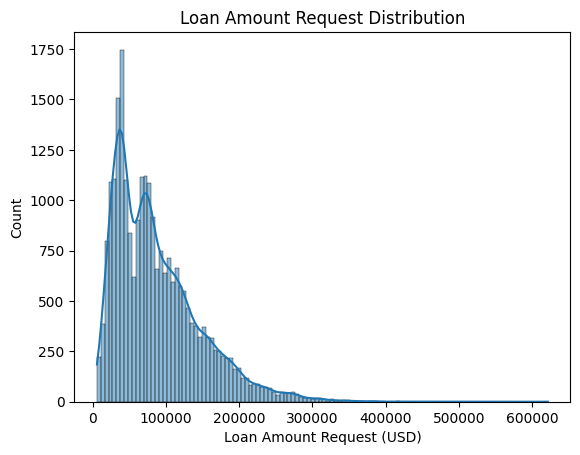

In [768]:
# Loan Amount
sns.histplot(df['Loan Amount Request (USD)'], kde=True)
plt.title('Loan Amount Request Distribution')
plt.show()

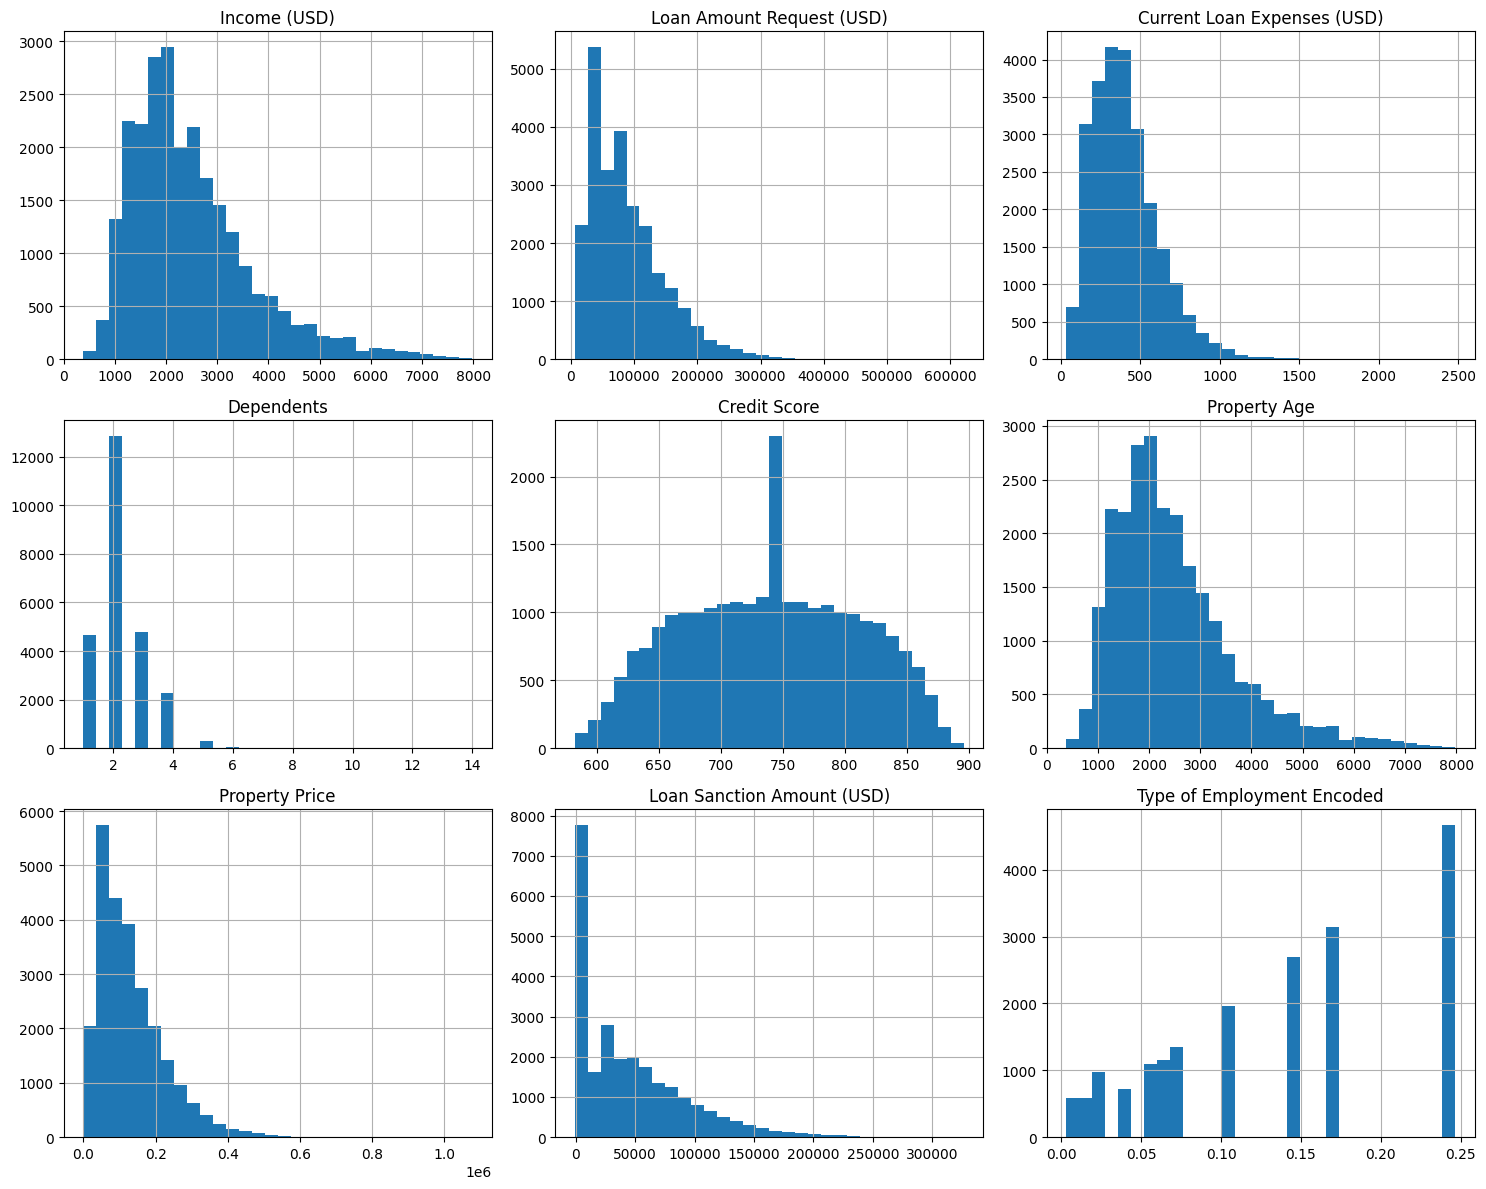

In [769]:
num_cols = df.select_dtypes(include=['float64']).columns
df[num_cols].hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()

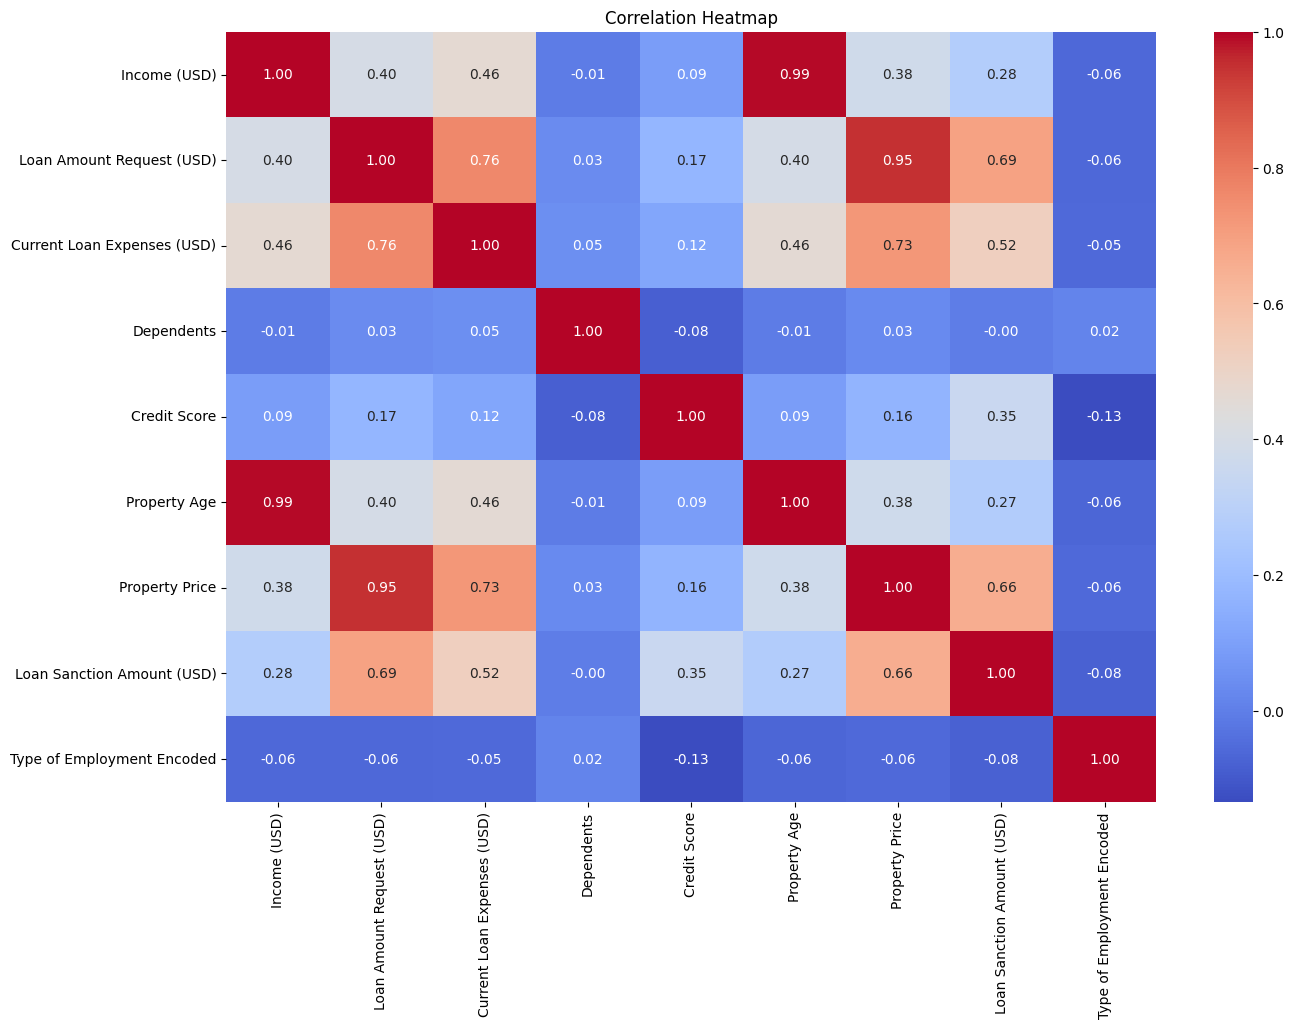

In [770]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

<Axes: xlabel='Gender_M', ylabel='Loan Sanction Amount (USD)'>

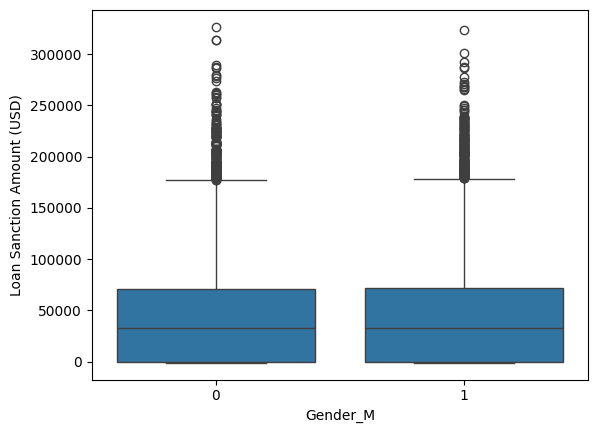

In [771]:
sns.boxplot(x='Gender_M', y='Loan Sanction Amount (USD)', data=df)

**Observations:**
- **Gender** does not show any significant correlation with any other variable
- Extremely high correlation between **Income** and **Property Age**
- Moderate positive correlation between **Loan Sanction Amount** and **Property Price**
- **Current Loan Expenses** and **Loan Amount Request**
- Moderate correlation between **Income Stability** and **Type of Employment**

In [772]:
# dropping columns due to very low correlation (and boxplot comparison with target var)
df.drop(columns=['Gender_M', 'Property Type', 'Has Active Credit Card'], inplace=True)

**4. Apply feature engineering techniques** to improve model performance.

Interaction feature:

In [774]:
df['Affordability'] = np.log1p(df['Income (USD)'] / (df['Property Price'] + 1e-6))

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [775]:
df = df.dropna()

**5. Split the dataset into training, testing, and validation sets**

5-Fold Cross Validation:

No of samples for Validation   

=  Total samples / 5

=  100 / 5  =  20


Training = 80%
Validation = 20%

**6. Train the Linear Regression model on the training set**

**7. Evaluate the model on the testing and validation sets.**

**8. Measure performance using metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R2 score.**

In [776]:
X = df.drop(columns=["Loan Sanction Amount (USD)"])  # everything except target
y = df["Loan Sanction Amount (USD)"]  # target variable

kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()

mae_list, mse_list, rmse_list, r2_list, all_actuals, all_predictions = [], [], [], [], [], []

for fold, (train_index, val_index) in enumerate(kf.split(X), start=1):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    all_actuals.extend(y_val)
    all_predictions.extend(y_pred)

    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"Fold {fold} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")

avg_mae = np.mean(mae_list)
avg_mse = np.mean(mse_list)
avg_rmse = np.mean(rmse_list)
avg_r2 = np.mean(r2_list)

print("\nAverage MAE:", avg_mae)
print("Average MSE:", avg_mse)
print("Average RMSE:", avg_rmse)
print("Average R2:", avg_r2)

Fold 1 - MAE: 0.43, MSE: 0.40, RMSE: 0.64, R2: 0.6323
Fold 2 - MAE: 0.43, MSE: 0.40, RMSE: 0.63, R2: 0.6287
Fold 3 - MAE: 0.46, MSE: 0.44, RMSE: 0.67, R2: 0.6208
Fold 4 - MAE: 0.43, MSE: 0.39, RMSE: 0.62, R2: 0.6581
Fold 5 - MAE: 0.44, MSE: 0.44, RMSE: 0.66, R2: 0.5926

Average MAE: 0.4408715112721679
Average MSE: 0.4145599607920346
Average RMSE: 0.6436476622798699
Average R2: 0.6264977748113167


**9. Visualize the results:**
- Plot predicted vs actual values
- Visualize feature importance or coefficients

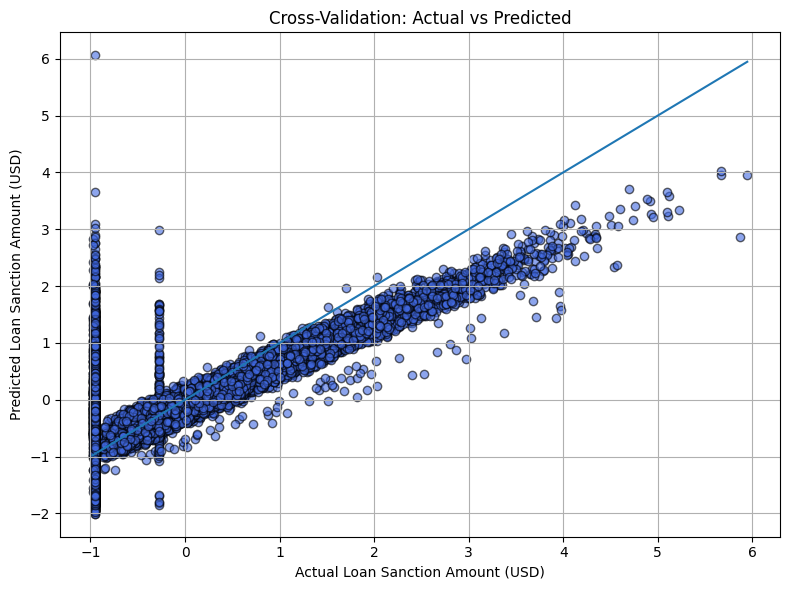

In [777]:
all_actuals = np.array(all_actuals)
all_predictions = np.array(all_predictions)

# actual vs predicted plot
plt.figure(figsize=(8, 6))
plt.scatter(all_actuals, all_predictions, alpha=0.6, color='royalblue', edgecolor='k')
plt.plot([all_actuals.min(), all_actuals.max()],
         [all_actuals.min(), all_actuals.max()])
plt.xlabel("Actual Loan Sanction Amount (USD)")
plt.ylabel("Predicted Loan Sanction Amount (USD)")
plt.title("Cross-Validation: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-778-2807331167.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coeff_df, x='Coefficient', y='Feature', palette='coolwarm')


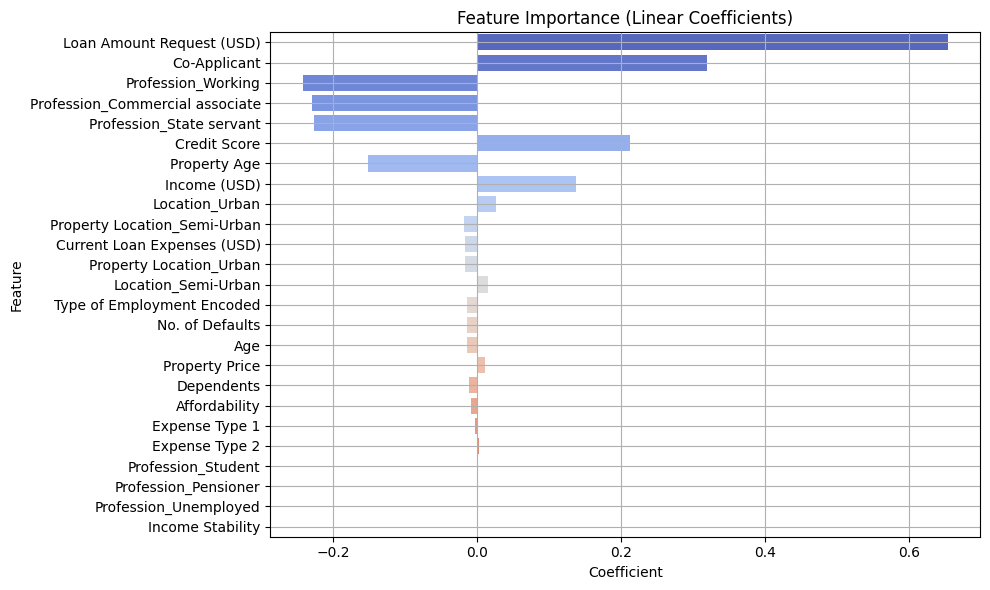

In [778]:
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
})

coeff_df = coeff_df.sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coeff_df, x='Coefficient', y='Feature', palette='coolwarm')
plt.title("Feature Importance (Linear Coefficients)")
plt.grid(True)
plt.tight_layout()
plt.show()

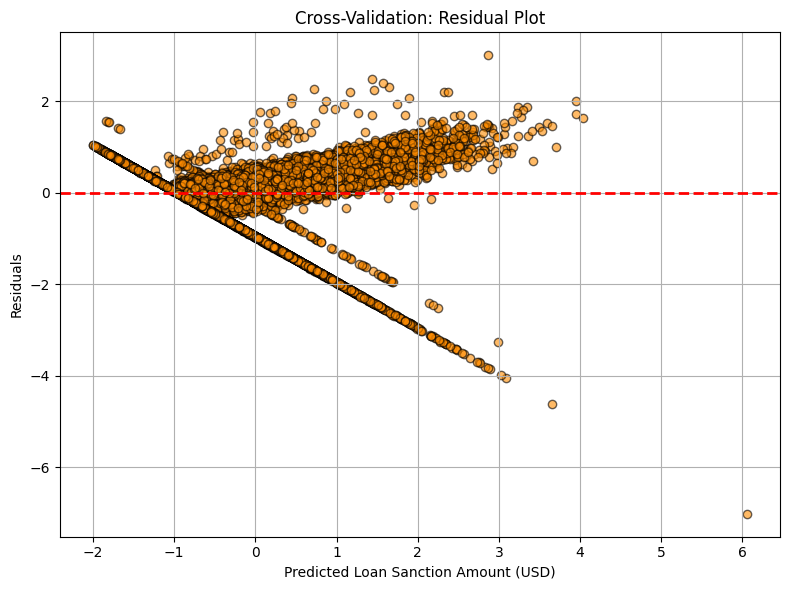

In [779]:
# residual plot
residuals = all_actuals - all_predictions

plt.figure(figsize=(8, 6))
plt.scatter(all_predictions, residuals, alpha=0.6, color='darkorange', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted Loan Sanction Amount (USD)")
plt.ylabel("Residuals")
plt.title("Cross-Validation: Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()